<a href="https://colab.research.google.com/github/atlanticstarr1/mnist/blob/main/mnist_resnet50v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# REFERENCES (REALLY GOOD)
# https://keras.io/examples/vision/consistency_training/
# https://github.com/keras-team/keras-io/blob/master/examples/vision/adamatch.py
# https://github.com/keras-team/keras-io/blob/master/examples/vision/ipynb/adamatch.ipynb

In [2]:
# %pip install --upgrade tensorflow
# %pip install tensorboard

In [3]:
# %pip install keras-cv
# %pip install tensorflow-addons
# %pip install scikit-plot
# %pip install tf-models-official

In [4]:
#%pip install -q ktrain

In [5]:
%matplotlib inline
import keras_cv
import tensorflow as tf
import numpy as np
import pandas as pd
from tensorflow import keras
import tensorflow_addons as tfa #maybe remove (SWA increases training time hugely)
import tensorflow_datasets as tfds
from keras import layers
#from keras_cv.layers import RandAugment
from keras.optimizers import Adam,RMSprop,SGD
from keras.utils import np_utils
from keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau,LearningRateScheduler,TensorBoard
from keras.losses import CategoricalCrossentropy,SparseCategoricalCrossentropy
import matplotlib.pyplot as plt
import time
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score,classification_report, confusion_matrix
from official.vision.ops import augment
import math
#from step_decay_schedule import step_decay_schedule
#from lr_finder import LRFinder
#from sgdr import SGDRScheduler
#from clr_callback import CyclicLR
#from learningratefinder import LearningRateFinder
#from lr_finder1 import lr_finder
#from fastai.vision.all import LRFinder
from lr_find import LrFinder
from one_cycle import OneCycleLr
import ktrain
from sklearn.model_selection import train_test_split

tfds.disable_progress_bar()
tf.random.set_seed(42)

In [6]:
# Load dataset
(train_set, valid_set, test_set) ,info= tfds.load("mnist", split=["train[:90%]", "train[90%:]", "test"],as_supervised=True, with_info=True)
# Extract informative features
class_names = info.features["label"].names
num_classes = info.features["label"].num_classes

In [7]:
## Define constants and hyperparameters
RESIZE_TO = 32
INPUT_SHAPE = 3
BATCH_SIZE = 512
DATA_SIZE = len(train_set)
EPOCHS = 60
AUTO = tf.data.AUTOTUNE
LEARNING_RATE = 0.001
STEPS_PER_EPOCH =math.ceil(DATA_SIZE / BATCH_SIZE)
TOTAL_STEPS = EPOCHS * STEPS_PER_EPOCH
# MIN_LR = 2.5e-6
# MAX_LR =1.5e-2
MIN_LR = 1e-4 # or 1.5e-4
MAX_LR = 1e-2
CLR_METHOD = "triangular2"
STEP_SIZE = 8 * STEPS_PER_EPOCH

In [8]:
# logs
%reload_ext tensorboard
log_folder = 'logs'

In [9]:
# Initialize `RandAugment`
# augmenter =keras_cv.layers.RandAugment(
#     value_range=(0, 255),
#     augmentations_per_image=3,
#     magnitude=0.9,
#     magnitude_stddev=0.2,
#     rate=0.5,
# )

In [10]:
# original_exclude_list= [
#     'AutoContrast', 'Equalize', 'Invert', 'Posterize', 'Solarize','Rotate',
#     'Color', 'Contrast', 'Brightness', 'Sharpness', 'ShearX', 'ShearY',
#     'TranslateX', 'TranslateY', 'Cutout', 'SolarizeAdd']
exclude_list= ['Equalize', 'Invert','Contrast', 'Posterize', 'Solarize','Color', 'Cutout', 'SolarizeAdd','Brightness','ShearX','ShearY','Sharpness','AutoContrast','TranslateX','TranslateY']
# augmenter = augment.RandAugment(exclude_ops=exclude_list)
augmenter = augment.image_ops.RandomRotation(0.1)
trainAug = tf.keras.Sequential([
    augment.image_ops.RandomRotation(0.1),
    augment.image_ops.RandomTranslation(0.1,0.1),
    augment.image_ops.RandomZoom(0.1,0.1)
])

In [11]:
# layers = keras_cv.layers.RandAugment.get_standard_policy(
#     value_range=(0, 255), magnitude=0.75, magnitude_stddev=0.3
# )

# layers = [
#     layer for layer in layers if not isinstance(layer, (keras_cv.layers.Equalization,keras_cv.layers.RandomColorDegeneration))
# ]

# pipeline =keras_cv.layers.RandomAugmentationPipeline(
#     layers=layers, augmentations_per_image=3
# )

In [12]:
# rand_aug = iaa.RandAugment(n=3, m=7)

# def augment(images):
#     # Input to `augment()` is a TensorFlow tensor which
#     # is not supported by `imgaug`. This is why we first
#     # convert it to its `numpy` variant.
#     images = tf.cast(images, tf.uint8)
#     return rand_aug(images=images.numpy())

In [13]:
# def tf_cv2_func(image, label):
#     [image] = tf.py_function(pipeline, [image], [tf.float32])
#     return image, label

In [14]:
def resize_and_rescale(image, label):
    # convert MNIST images to RGB
    image = tf.image.grayscale_to_rgb(image)
    image = tf.image.resize_with_pad(image, RESIZE_TO, RESIZE_TO)
    #image = tf.tile(image, [1, 1, 3])
    #image = tf.cast(image, tf.float32)
    label = tf.one_hot(label, num_classes)
    return image,label

def prepare_dataset(dataset, shuffle=False, augment=False):
    # Resize and rescale all datasets.
    dataset = dataset.map(resize_and_rescale, num_parallel_calls=AUTO)
    if shuffle:
        dataset = dataset.shuffle(DATA_SIZE,seed=42)
     # Batch all datasets.
    dataset = dataset.batch(BATCH_SIZE)
     # Use data augmentation only on the training set.
    if augment:
        #dataset = dataset.map(lambda x,y:(augmenter(x),y),num_parallel_calls=AUTO)
        dataset = dataset.map(lambda x,y:(augmenter(x),y),num_parallel_calls=AUTO)
        #dataset = dataset.map(lambda x,y:(trainAug(x,training=True),y),num_parallel_calls=AUTO)
    # Use buffered prefetching on all datasets.
    return dataset.prefetch(AUTO)

Generate datasets

In [15]:
train_dataset = prepare_dataset(train_set,shuffle=True)
train_dataset_aug = prepare_dataset(train_set,shuffle=True,augment=True)
val_dataset = prepare_dataset(valid_set)
test_dataset = prepare_dataset(test_set)

Inspect some samples from our dataset

In [16]:
def visualize_dataset(dataset, title):
    plt.figure(figsize=(6, 6)).suptitle(title, fontsize=18)
    for images,labels in dataset.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[tf.argmax(labels[i])])
            plt.axis("off")
    plt.show()

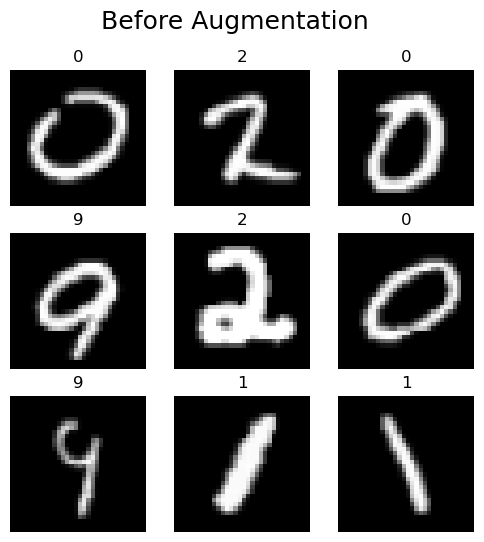

In [17]:
visualize_dataset(train_dataset, title="Before Augmentation")

In [18]:
#train_dataset_aug.save("./augment")

In [19]:
#new_dataset_aug = tf.data.Dataset.load("./augment")

In [20]:
# get total elements
# total = []
# for element in new_dataset_aug.as_numpy_iterator(): 
#   total.append(element[1])

# all_total = np.concatenate(total)
# print(len(all_total))

In [21]:
#visualize_dataset(new_dataset_aug, "augmented from disk")

Visualize after RandAugment

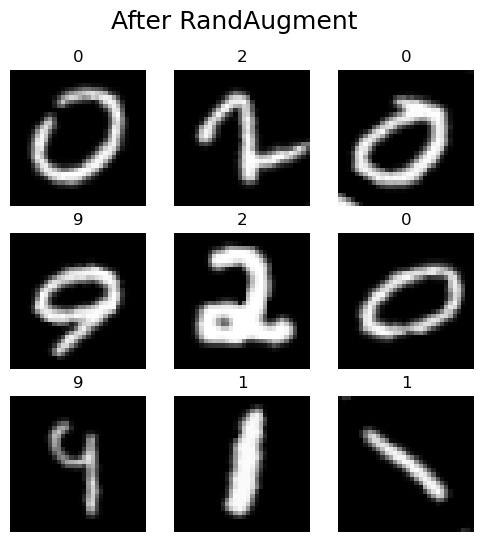

In [22]:
visualize_dataset(train_dataset_aug, title="After RandAugment")

In [23]:
# Define a model building utility function (ResNet50V2 architecture)
def get_training_model():
    resnet50_v2 = tf.keras.applications.ResNet50V2(
        weights="imagenet", include_top=False, input_shape=(RESIZE_TO, RESIZE_TO, INPUT_SHAPE)
    )
    model = tf.keras.Sequential(
        [
            keras.layers.Input((RESIZE_TO, RESIZE_TO, INPUT_SHAPE)),
            keras.layers.Rescaling(scale=1.0 / 255.0),
            resnet50_v2,
            keras.layers.GlobalAveragePooling2D(),
            keras.layers.Dense(num_classes),
        ]
    )
    return model

In [24]:
# my_model = get_training_model()
# my_model.compile(
#     optimizer=Adam(),
#     loss=CategoricalCrossentropy(from_logits=True),
#     metrics=["accuracy"]
# )
# learner = ktrain.get_learner(my_model, train_data=(np.array(x_train),y_train), val_data = (np.array(x_validate),y_validate),batch_size=BATCH_SIZE)

In [25]:
#learner.lr_find()

In [26]:
# learner.lr_plot(suggest=True)

In [27]:
# # reinitialize the model to train from scratch 
# my_model = get_training_model()
# my_model.compile(
#     optimizer=Adam(),
#     loss=CategoricalCrossentropy(from_logits=True),
#     metrics=["accuracy"]
# )
# learner.set_model(my_model)
# # training using cycle_len 
# learner.fit(6.70E-05, 1, cycle_len=60)

Finding best initial lr over 106 steps


  0%|          | 0/106 [00:00<?, ?it/s]

LR Finder is complete, type {LrFinder}.plot_lrs() to see the graph.
Min numerical gradient (min_lr): 8.78E-01
Min loss divided by 10 (max_lr): 2.28E-03


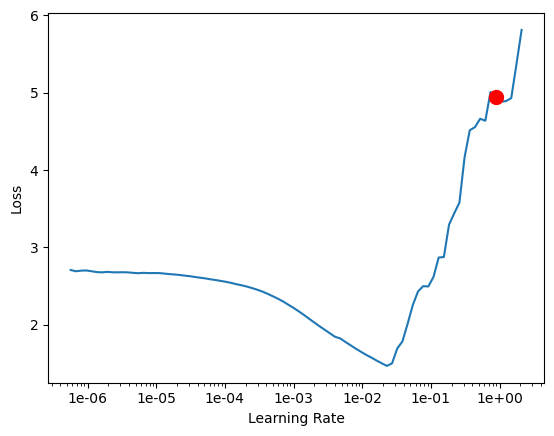

In [28]:
# Get model
optimizer = Adam()
loss_fn = CategoricalCrossentropy(from_logits=True)
my_model = get_training_model()
# my_model.compile(
#     optimizer=optimizer,
#     loss=loss_fn,
#     metrics=["accuracy"]
# )

my_model.save_weights("initial_weights.h5")

# Instantiate LrFinder
lr_find = LrFinder(my_model, optimizer, loss_fn)

# Start range_test
lr_find.range_test(train_dataset,num_iter=STEPS_PER_EPOCH)
lr_find.plot_lrs(skip_end=0,suggestion=True)

In [29]:
# get optimal learning rates
min, min_idx = lr_find.minimum() # ideally the optimal learning rate but may cause divergence. smallest learning rate
#max_lr = (min/10.0) if min*100.0<=10.0 else (min/100.0) # the recommended maximum learning rate is much less than the learning rate at which the loss is the smallest. optimal learning rate.
max_lr = (min/10.0)
min_lr, steep_idx = lr_find.steep() # the baseline/ lowest learning rate is the value at which the loss reduces the fastest (minimal negative gradient) - steepest point.
valley, valley_idx = lr_find.valley()
slide, slide_idx = lr_find.slide() #try adjusted values: 0.5,0.01,0.05 or try increasing lr_diff to bigger values

# https://forums.fast.ai/t/new-lr-finder-output/89236/2
# Valley > Slide > Steep > Minimum


In [30]:
# show possible learning rates
print("max_lr:", max_lr)    #optimal learning rate
print("min_lr:", min_lr)    #min learning rate
print("valley:", valley)
print("slide:", slide)
print("min_grad:", min)
print("min loss:", min_idx)

max_lr: 0.0022829193621873856
min_lr: 0.8778013
valley: 0.0001478466
slide: 0.0010000000474974513
min_grad: 0.022829194
min loss: 1.4661613


In [31]:
# take mean
from statistics import harmonic_mean,geometric_mean
geo_rate = geometric_mean([max_lr,min_lr])
har_mean = harmonic_mean([max_lr,min_lr])
print("geometric mean: ",geo_rate)
print("harmonic mean: ",har_mean)

geometric mean:  0.04476549543853577
harmonic mean:  0.0045539950378162605


In [32]:
# lrf = lr_finder(my_model,begin_lr=1e-8, end_lr=1e0, num_epochs=10)
# lr_rate = LearningRateScheduler(lrf.lr_schedule)
# lrf.model.compile(
#     optimizer=Adam(),
#     loss=CategoricalCrossentropy(from_logits=True),
#     metrics=["accuracy"],
# )
# lr_history = lrf.model.fit(
#     train_dataset,
#     epochs=10,
#     validation_data=val_dataset,
#     callbacks=[lr_rate],
# )

# lrf.lr_plot(lr_history.history['loss'])

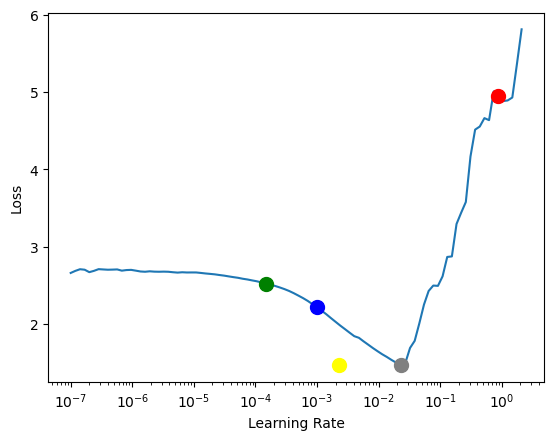

In [33]:
# plot optimal learning rates
_, ax = plt.subplots(1, 1)
ax.plot(lr_find.lrs, lr_find.losses)
ax.plot(max_lr, min_idx,markersize=10,marker="o", color="yellow")  # max_lr
ax.plot(min_lr, steep_idx, markersize=10,marker="o", color="red") # min_lr
ax.plot(valley, valley_idx, markersize=10,marker="o", color="green") #valley
ax.plot(slide,slide_idx,markersize=10,marker="o", color="blue")  #slide
ax.plot(min,min_idx,markersize=10,marker="o", color="gray")  #min loss
ax.set_ylabel("Loss")
ax.set_xlabel("Learning Rate")
ax.set_xscale("log")

In [34]:
def lr_function(epoch):
    start_lr = 1e-4; min_lr = 1e-4; max_lr = 0.0016    #A
    rampup_epochs = 5; sustain_epochs = 0; exp_decay = .80    #B

    def lr(epoch, start_lr, min_lr, max_lr, rampup_epochs,
        sustain_epochs, exp_decay):
        if epoch < rampup_epochs:    #C
            lr = ((max_lr - start_lr) / rampup_epochs
                        * epoch + start_lr)
        elif epoch < rampup_epochs + sustain_epochs:    #D
            lr = max_lr
        else:    #E
            lr = ((max_lr - min_lr) *
                    exp_decay**(epoch - rampup_epochs -
                                    sustain_epochs) + min_lr)
        return lr

    return lr(epoch, start_lr, min_lr, max_lr,
            rampup_epochs, sustain_epochs, exp_decay)


In [76]:
# for sgdr use this config
# min_lr = 1e-9
# if max_lr <= min_lr:
#     min_lr = max_lr / 10
one_c = OneCycleLr(max_lr=0.0016, total_steps=TOTAL_STEPS)
#lr_sched = step_decay_schedule(initial_lr=min_lr, decay_factor=0.75, step_size=5)
#schedule = SGDRScheduler(min_lr=valley,max_lr=max_lr,steps_per_epoch=STEPS_PER_EPOCH,lr_decay=0.9,cycle_length=5,mult_factor=1.5)
#optimizer = tfa.optimizers.AdamW(weight_decay=1e-5)
clr = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=1e-4,
    maximal_learning_rate=0.0016,
    scale_fn=lambda x: 1/(2.**(x-1)),
    step_size=4* STEPS_PER_EPOCH
)
optimizer = tf.keras.optimizers.Adam(clr)
# clr1 = CyclicLR(
# 	mode=CLR_METHOD,
# 	base_lr=1e-6,
# 	max_lr= 0.002,
# 	step_size= STEP_SIZE)

callbacks = [
    #one_c,
    #schedule,
    #clr,
    #lr_sched,
    #LearningRateScheduler(lr_function),
    tf.keras.callbacks.TerminateOnNaN(),
    ReduceLROnPlateau(patience=3, factor=0.5),
    EarlyStopping(patience=20, restore_best_weights=True),
    ModelCheckpoint(filepath='final_model.h5',save_weights_only=True,save_best_only=True)
    ]
my_model=get_training_model()
my_model.load_weights("initial_weights.h5")
my_model.compile(
    #optimizer=tfa.optimizers.AdamW(learning_rate=0.001, weight_decay=1e-5),
    optimizer=Adam(max_lr),
    #optimizer=optimizer,
    loss=CategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

history = my_model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/60
106/106 [==============================] - 24s 173ms/step - loss: 0.3935 - accuracy: 0.8908 - val_loss: 14.1463 - val_accuracy: 0.6628 - lr: 0.0023
Epoch 2/60
106/106 [==============================] - 18s 158ms/step - loss: 0.0576 - accuracy: 0.9859 - val_loss: 61.5216 - val_accuracy: 0.8418 - lr: 0.0023
Epoch 3/60
106/106 [==============================] - 18s 163ms/step - loss: 0.0406 - accuracy: 0.9894 - val_loss: 0.2123 - val_accuracy: 0.9653 - lr: 0.0023
Epoch 4/60
106/106 [==============================] - 18s 158ms/step - loss: 0.0324 - accuracy: 0.9911 - val_loss: 0.5217 - val_accuracy: 0.9597 - lr: 0.0023
Epoch 5/60
106/106 [==============================] - 18s 162ms/step - loss: 0.0286 - accuracy: 0.9921 - val_loss: 0.0728 - val_accuracy: 0.9843 - lr: 0.0023
Epoch 6/60
106/106 [==============================] - 18s 162ms/step - loss: 0.0218 - accuracy: 0.9940 - val_loss: 0.0488 - val_accuracy: 0.9880 - lr: 0.0023
Epoch 7/60
106/106 [==============================

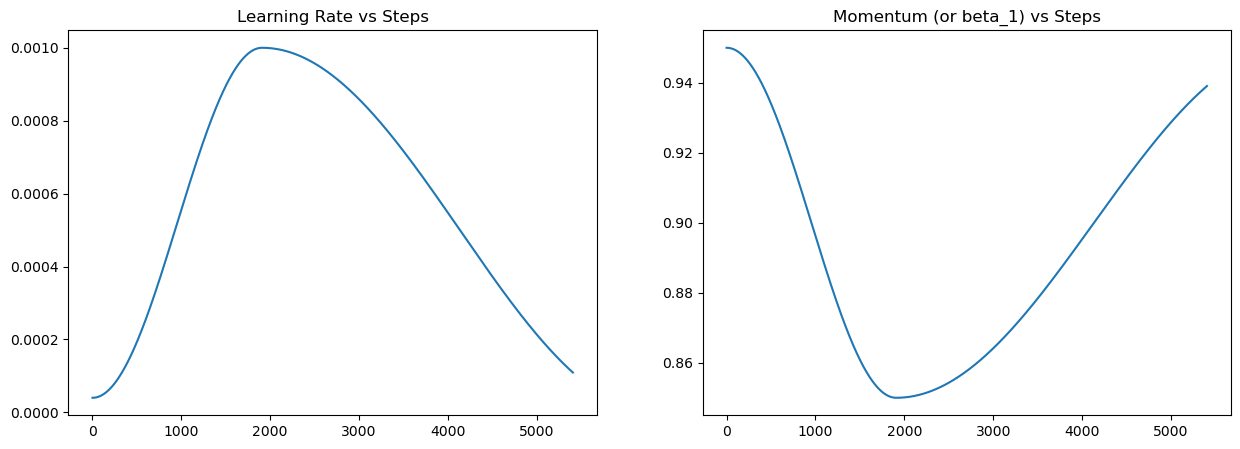

In [37]:
# to plot the learning_rate & momentum(or beta_1) graphs
one_c.plot_lrs_moms()

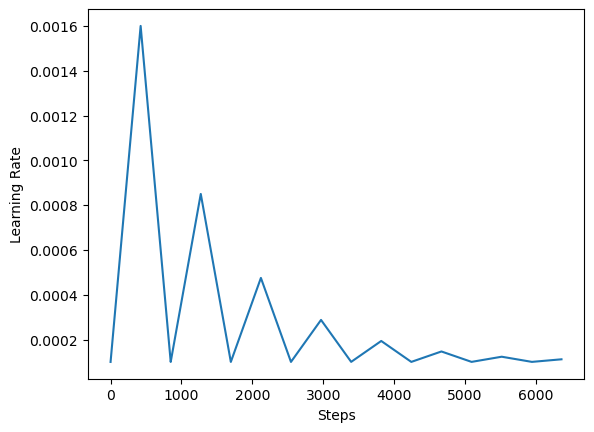

In [77]:
step = np.arange(0, EPOCHS * STEPS_PER_EPOCH)
lr = clr(step)
plt.plot(step, lr)
plt.xlabel("Steps")
plt.ylabel("Learning Rate")
plt.show()

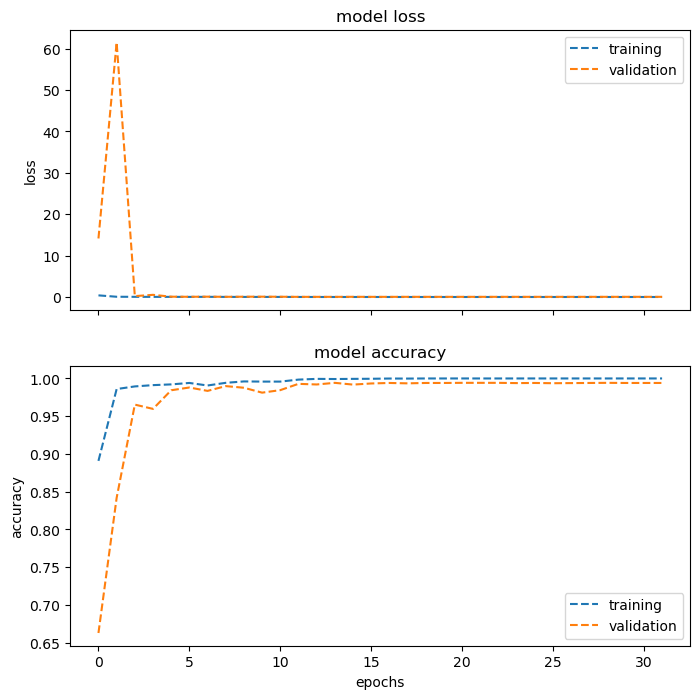

In [82]:
# plot loss during training
fig, (ax1, ax2) = plt.subplots(2, 1,sharex=True, figsize=(8,8))
ax1.set_title("model loss")
ax1.plot(history.history['loss'],'--')
ax1.plot(history.history['val_loss'],'--')
ax1.legend(['training', 'validation'],loc='best')
ax1.set_ylabel('loss')
# plot accuracy during training
ax2.set_title("model accuracy")
ax2.plot(history.history['accuracy'],'--')
ax2.plot(history.history['val_accuracy'],'--')
ax2.legend(['training', 'validation'], loc='best')
ax2.set_xlabel('epochs')
ax2.set_ylabel('accuracy')
plt.show()

In [79]:
# Evaluate the teacher model on the test set.
_,acc = my_model.evaluate(test_dataset, verbose=0)
print(f"Accuracy: {acc * 100:.2f}%")

Accuracy: 99.34%


In [ ]:
## TRAIN THE MODEL

# Initialize SWA from tensorflow
# SWA = tfa.optimizers.SWA
# LEARNING_RATE = 0.003
# lr_end = 1e-4
# reduce_lr = tf.keras.optimizers.schedules.CosineDecay(LEARNING_RATE, TOTAL_STEPS,alpha=0.25)
# def cosine_decay(epoch):
#     if EPOCHS > 1:
#         w = (1 + math.cos(epoch / (EPOCHS - 1) * math.pi)) / 2
#     else:
#         w = 1
#     return w * LEARNING_RATE + (1 - w) * lr_end

# Compile and train the teacher model.
teacher_model = get_training_model()
#teacher_model.load_weights("initial_teacher_model.h5")
optimizer = tfa.optimizers.AdamW(learning_rate=1e-3, weight_decay=1e-5)
teacher_model.compile(
    # Wrap optimizer within SWA
    optimizer=Adam(),
    loss=CategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

# maxEpochs = EPOCHS
# power = 5
# def poly(epoch):
#     decay = (1 - (epoch / float(maxEpochs))) ** power
#     alpha = LEARNING_RATE * decay
#     return float(alpha)

# dropEvery = 5
# factor = 0.7
# def step(epoch):
#     exp = np.floor((1 + epoch) / dropEvery)
#     alpha = LEARNING_RATE * (factor ** exp)
#     return float(alpha)

#teacher_model.summary()

# lr_sched = step_decay_schedule(initial_lr=LEARNING_RATE, decay_factor=0.75, step_size=3)

# lr_finder = LRFinder(min_lr=1e-9, max_lr=0.1, steps_per_epoch=STEPS_PER_EPOCH, epochs=EPOCHS)

# schedule = SGDRScheduler(min_lr=0.0001,max_lr=0.003,steps_per_epoch=STEPS_PER_EPOCH,lr_decay=0.9,cycle_length=5,mult_factor=1.5)

# clr = CyclicLR(
# 	mode=CLR_METHOD,
# 	base_lr=MIN_LR,
# 	max_lr=MAX_LR,
# 	step_size= STEP_SIZE)

# Define the callbacks.
model_checkpoint = ModelCheckpoint(
    filepath='final_teacher_model.h5',
    save_weights_only=True,
    save_best_only=True)

#tensorboard_callback = TensorBoard(log_dir=log_folder, histogram_freq=1, write_graph=True)

callbacks = [
    #ReduceLROnPlateau(patience=8),
    EarlyStopping(patience=15, restore_best_weights=True),
    model_checkpoint
    ]

start = time.perf_counter()

# lrf = LearningRateFinder(teacher_model)
# lrf.find(train_dataset.repeat(),1e-10, 1e+1,stepsPerEpoch=STEPS_PER_EPOCH,batchSize=BATCH_SIZE)
# lrf.plot_loss()

# lrf = lr_finder(get_training_model(),begin_lr=1e-8, end_lr=1e0, num_epochs=10)
# lr_rate = LearningRateScheduler(lrf.lr_schedule)
# lrf.model.compile(
#     optimizer=Adam(),
#     loss=CategoricalCrossentropy(from_logits=True),
#     metrics=["accuracy"],
# )
# lr_history = lrf.model.fit(
#     train_dataset,
#     epochs=10,
#     validation_data=val_dataset,
#     callbacks=[lr_rate],
# )

# lrf.lr_plot(lr_history.history['loss'])

# history = teacher_model.fit(
#     train_dataset,
#     epochs=EPOCHS,
#     validation_data=val_dataset,
#     callbacks=callbacks,
# )

duration = time.perf_counter()-start
hrs=int(duration/3600)
mins=int((duration-hrs*3600)/60)
secs= duration-hrs*3600-mins*60
msg='The training cycle took {0} hours {1} minutes and{2:6.2f} seconds'
print(msg.format(hrs, mins,secs))

In [ ]:
# take the geometric mean of learning rates
# learning_rate = (lrf.lower_bound*lrf.upper_bound)**(1/2)
# print(learning_rate)


In [ ]:
# model = get_training_model()
# model.compile(
#     optimizer=Adam(learning_rate),
#     loss=CategoricalCrossentropy(from_logits=True),
#     metrics=["accuracy"],
# )

# history = model.fit(
#     train_dataset,
#     epochs=50,
#     validation_data=val_dataset
# )

In [ ]:
# lrs = lrf.lrs[10:-1]
# losses = lrf.losses[10:-1]
# fig, ax = plt.subplots()
# ax.plot(lrs,losses)
# ax.set_xscale('log')
# ax.vlines(x=[2.5e-6],ymin=0,ymax=3) #min/base
# ax.vlines(x=[1.5e-2],ymin=0,ymax=3) #max
# ax.vlines(x=[4e-4],ymin=0,ymax=3) #sweet spot
# ax.hlines(y=[lrf.bestLoss],xmin=0,xmax=1)
# plt.xlabel("Learning rate")
# plt.ylabel("Accuracy")
# plt.show()

In [ ]:
# x=lr_finder.history['lr']
# y=lr_finder.history['loss']
# accuracy=lr_finder.history['accuracy']

# fig, ax = plt.subplots()
# ax.plot(x,y)
# ax.set_xscale('log')
# ax.vlines(x=[1e-2],ymin=0,ymax=3)
# ax.vlines(x=[1e-4],ymin=0,ymax=3)
# plt.xlabel("Learning rate")
# plt.ylabel("loss")
# plt.show()

# i_max = np.argmax(np.abs(np.gradient(x)))
# print(i_max)
# print (y[i_max]) 

In [ ]:
# plot loss during training
fig, (ax1, ax2) = plt.subplots(2, 1,sharex=True, figsize=(8,8))
ax1.set_title("model loss")
ax1.plot(history.history['loss'],'--')
ax1.plot(history.history['val_loss'],'--')
ax1.legend(['training', 'validation'],loc='best')
ax1.set_ylabel('loss')
# plot accuracy during training
ax2.set_title("model accuracy")
ax2.plot(history.history['accuracy'],'--')
ax2.plot(history.history['val_accuracy'],'--')
ax2.legend(['training', 'validation'], loc='best')
ax2.set_xlabel('epochs')
ax2.set_ylabel('accuracy')
plt.show()

In [ ]:
# Evaluate the teacher model on the test set.
_,acc = teacher_model.evaluate(test_dataset, verbose=0)
print(f"Accuracy: {acc * 100:.2f}%")

In [ ]:
# Generate predictions
y_pred = teacher_model.predict(test_dataset,verbose=0)
y_pred = y_pred.argmax(axis=1) # predicted labels
y_true = np.concatenate([y for x,y in test_dataset]).argmax(axis=1) # true labels

In [ ]:
# Evaluate predictions
acc = accuracy_score(y_true, y_pred)
precision =precision_score(y_true,y_pred,average="macro")
recall =recall_score(y_true,y_pred,average="macro")
f1score =f1_score(y_true,y_pred,average="macro")
print("Accuracy = %4.4f" %acc)
print("Precision = %4.4f" %precision)
print("Recall = %4.4f" %recall)
print("F1-score = %4.4f" %f1score)

In [ ]:
print(classification_report(y_true, y_pred, digits=4))

In [ ]:
pd.DataFrame(confusion_matrix(y_true, y_pred))

In [ ]:
model = get_training_model()
model.load_weights('final_teacher_model.h5')
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss=CategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)
model.evaluate(test_dataset)